# Spectral differentiation

We have seen that a function $f$ can be written in terms of the DFT as

\begin{equation}
f_n = \sum_{k=0}^{N-1} F_k e^{\frac{i2\pi kn}{N}}
\end{equation}

where $x_n=2\pi n/N$ for a $0\leq n\leq 2\pi$ domain. Replacing gives,

\begin{equation}
f(x_n) = \sum_{k=0}^{N-1} F_k e^{ix_nk}
\end{equation}

Let's take the derivative f'(x_n):

\begin{equation}
f'(x_n) = \sum_{k=0}^{N-1} ikF_k e^{ix_nk}
\end{equation}

we end up with the same Fourier-expansion-type of expression, where the DFT is $ikF_k$, rather than $F_k$. What if we take a second derivative?

\begin{equation}
f''(x_n) = \sum_{k=0}^{N-1} -k^2F_k e^{ix_nk}
\end{equation}

can you see the pattern here? The $j^{th}$ derivative is then

\begin{equation}
f^{(j)}(x_n) = \sum_{k=0}^{N-1} (ik)^jF_k e^{ix_nk}
\end{equation}

This becomes very useful for approximating derivatives. What if we take the DFT, multiply times $(ik)^j$ for the $j^{th}$ derivative, and then take the inverse DFT? Let's try that out!

## Example: differentiation of periodic function

Let's try this on $f(x) = \frac{1}{1+\sin^2(x)}$, and compare it against its analytical solution $f'(x) = -\frac{2\sin(x)\cos(x)}{(\sin^2(x)+1)^2}$

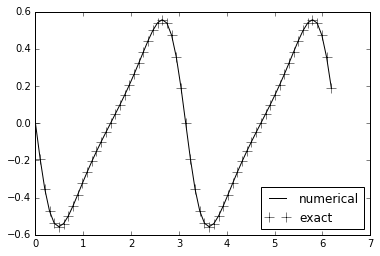

In [12]:
import numpy
import numpy.fft
from matplotlib import pyplot
%matplotlib inline

def spectral_diff(function, x):
    """
    Takes the spectral derivative of a function  
    Input:
    ------
        function: 'def' type function that computes the value of the function to
                    differentiate 
        x: (array of float) collocation points
    Returns:
    -------
        df: (array of float) approximated derivative
    """
    
    f = function(x)

    N = len(x)
    k = numpy.arange(N/2+1)
    
    f_hat = numpy.fft.rfft(f)/N
    df_hat = 1j*k*f_hat
    
    df = numpy.fft.irfft(df_hat)*N
    
    return df

def function_0(x):
    return 1./(1.+numpy.sin(x)**2)

def function_0_diff(x):
    return -2*numpy.sin(x)*numpy.cos(x)/((numpy.sin(x)**2+1)**2)

N = 64
xmin = 0.
xmax = 2*numpy.pi

x = numpy.linspace(xmin, xmax, N, endpoint=False)

df = spectral_diff(function_0, x)
df_exact = function_0_diff(x)

pyplot.plot(x, df, c='k', ls='-', marker='', label='numerical')
pyplot.plot(x, df_exact, c='k', ls='', marker='+', ms=10, label='exact')
pyplot.legend(loc='best')

Looks good! Let's study convergence

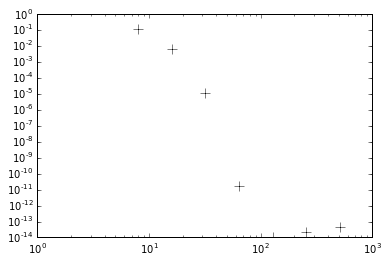

In [13]:
def L2_error(f, f_exact):
    return numpy.sqrt(numpy.sum((f-f_exact)**2)/numpy.sum(f_exact**2))

def convergence_test(N_array, function, function_diff):

    error = numpy.array([])
    for N in N_array:
    
        x = numpy.linspace(xmin, xmax, N, endpoint=False)
    
        df = spectral_diff(function, x)
        df_exact = function_diff(x)
        
        e = L2_error(df, df_exact)
    
        error = numpy.append(error,e)    

    pyplot.loglog(N_array, error, ls='', marker='+', c='k', ms=10)
    
N_array = numpy.array([8, 16, 32, 64, 128, 256, 512])
convergence_test(N_array, function_0, function_0_diff)

Pretty much spectral to me!

## Example: differentiation of non periodic function
Let's approximate the derivative of $f(x) = e^x\sin(5x)$ using FFTs

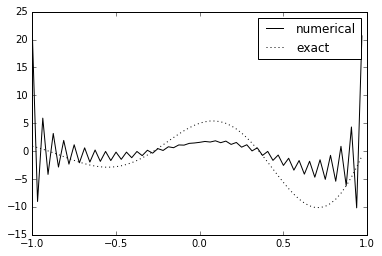

In [14]:
def function_1(x):
    return numpy.exp(x)*numpy.sin(5*x)

def function_1_diff(x):
    return numpy.exp(x)*numpy.sin(5*x) + 5*numpy.exp(x)*numpy.cos(5*x) 

N = 64
xmin = -1.
xmax = 1.

x = numpy.linspace(xmin, xmax, N, endpoint=False)

df = spectral_diff(function_1, x)
df_exact = function_1_diff(x)

pyplot.plot(x, df, c='k', ls='-', marker='', label='numerical')
pyplot.plot(x, df_exact, c='k', ls=':', marker='', ms=10, label='exact')
pyplot.legend(loc='best')

Let's look at the errors

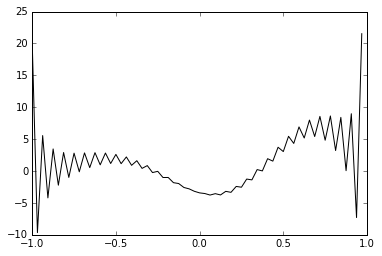

In [15]:
error_point = df-df_exact
pyplot.plot(x, error_point, c='k')

This doesn't look good. Like before, we have problems at the boundaries. What if we use the Chebyshev transform we saw before? Note that for the Chebyshev points there is no `endpoint=False`, meaning that the end-points are *considered twice*. This makes sense, considering that the function is no longer periodic.

Even though we know the Chebyshev transform is a discrete cosine transform on Chebyshev points, we still wan to use the efficient FFT. Next, we define a function that computes the Chebyshev transform using FFTs. This was taken from Trefethen's *Spectral Methods in Matlab*.

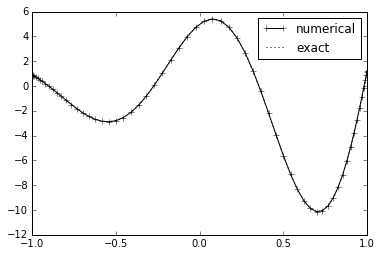

In [16]:
def chebfft_diff(function, x):
    
    N = len(x)
    f = function(x)
    f = numpy.ravel(f)
    ii = numpy.arange(N-1)
    K =  numpy.zeros(2*(N-1))
    K[0:N-1] = ii[:]
    K[N:2*(N-1)] = -numpy.flipud(ii[1:])
    y = numpy.append(f, numpy.flipud(f[1:N-1]))
    y_t = numpy.real(numpy.fft.fft(y))
    df = numpy.real(numpy.fft.ifft(1j*K*y_t))
    w = numpy.zeros(N)
    w[1:N-1] = -df[1:N-1]/numpy.sqrt(1-x[1:N-1]**2)
    w[0] = numpy.sum(ii**2*y_t[ii])/(N-1) + 0.5*(N-1)*y_t[N-1]
    w[-1] = numpy.sum((-1)**(ii+1)*ii**2*y_t[ii])/(N-1) + 0.5*(-1)**(N)*(N-1)*y_t[N-1]
    
    return w


x_cheb = numpy.cos(numpy.linspace(0., 1., N)*numpy.pi) 

df_cheb = chebfft_diff(function_1, x_cheb)
df_cheb_exact = function_1_diff(x_cheb)

pyplot.plot(x_cheb, df_cheb, c='k', ls='-', marker='+', label='numerical')
pyplot.plot(x_cheb, df_cheb_exact, c='k', ls=':', marker='', ms=10, label='exact')
pyplot.legend(loc='best')

Looks better! What about point-wise errors?

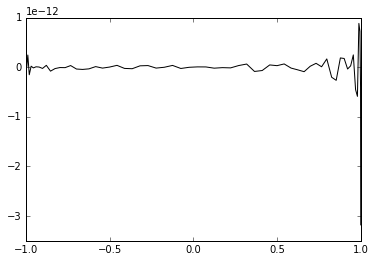

In [17]:
error_point = df_cheb - df_cheb_exact
pyplot.plot(x_cheb, error_point, c='k')

Nice! How about convergence rate?

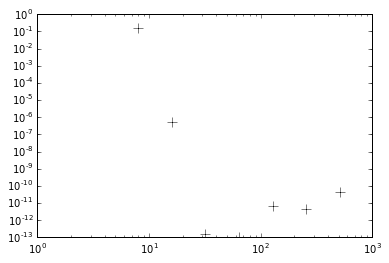

In [18]:
def convergence_test_cheb(N_array, function, function_diff):

    error_cheb = numpy.array([])
    for N in N_array:
    
        x_cheb = numpy.cos(numpy.linspace(0.,1.,N)*numpy.pi)
    
        df_cheb = chebfft_diff(function, x_cheb)
        df_cheb_exact = function_diff(x_cheb)
        
        e_cheb = L2_error(df_cheb, df_cheb_exact)
    
        error_cheb = numpy.append(error_cheb,e_cheb)    

    pyplot.loglog(N_array, error_cheb, ls='', marker='+', c='k', ms=10)
    
N_array = numpy.array([8, 16, 32, 64, 128, 256, 512])
convergence_test_cheb(N_array, function_1, function_1_diff)

It falls very quickly *close to* machine precision!